# Unimodality

$\begin{align}
p(\mathbf{y}, \mathbf{f}, \mathbf{f}', \mathbf{z}, \mathbf{g}, \mathbf{g}', \mathbf{m}) = \frac{1}{Z}\mathcal{N}\left(\textbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \phi\left(z_if_i'\right)\prod_{i=1}^M \text{Ber}\left(z_i|\phi\left(g_i\right)\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) 
\end{align}$,

where $m$ is  the set of gradient observations for g, and  $z \in \left\lbrace-1, 1\right\rbrace$ is  the set of gradient observations.

Re-write

$\begin{align}
p(\mathbf{y}, \mathbf{f}, \mathbf{f}', \mathbf{z}, \mathbf{g}, \mathbf{g}', \mathbf{m}) = \frac{1}{Z}\mathcal{N}\left(\textbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \phi\left(z_if_i'\right) \text{Ber}\left(z_i|\phi\left(g_i\right)\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) 
\end{align}$,

Marginalize wrt. $\mathbf{z}$

$\begin{align}
p(\mathbf{y}, \mathbf{f}, \mathbf{f}', \mathbf{g}, \mathbf{g}', \mathbf{m}) = \sum_{\mathbf{z}}\frac{1}{Z}\mathcal{N}\left(\textbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \phi\left(z_if_i'\right) \text{Ber}\left(z_i|\phi\left(g_i\right)\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) 
\end{align}$,


### Marginal likelihood

$\begin{align}
p(\mathbf{y}, \mathbf{f}, \mathbf{f}', \mathbf{g}, \mathbf{g}', \mathbf{m}) &\propto \int \!\!\!\!\int \!\!\!\! \int \!\!\!\!\int \sum_{\mathbf{z}}\frac{1}{Z}\mathcal{N}\left(\textbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \phi\left(z_if_i'\right) \text{Ber}\left(z_i|\phi\left(g_i\right)\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) \text{d}\mathbf{f}\text{d}\mathbf{f}'\text{d}\mathbf{g}\text{d}\mathbf{g}'\\
%
&\propto \int \!\!\!\!\int \!\!\!\! \int \!\!\!\!\int \frac{1}{Z}\mathcal{N}\left(\textbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \left[\phi\left(-f_i'\right)(1-\phi(g_i)) + \phi\left(f_i'\right)\phi(g_i)\right]  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) \text{d}\mathbf{f}\text{d}\mathbf{f}'\text{d}\mathbf{g}\text{d}\mathbf{g}'
\end{align}$


Inserting site approximations

$\begin{align}
p(\mathbf{y}, \mathbf{f}, \mathbf{f}', \mathbf{g}, \mathbf{g}', \mathbf{m}) &\propto \int \!\!\!\!\int \!\!\!\! \int \!\!\!\!\int \frac{1}{Z}\mathcal{N}\left(\textbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M c_i\mathcal{N}\left(f_i'|m^f_i, v^f_i\right)\mathcal{N}\left(g_i|m^g_i, v^g_i\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M k_i \mathcal{N}\left(g_i'|\mu_i, \tau_i\right) \text{d}\mathbf{f}\text{d}\mathbf{f}'\text{d}\mathbf{g}\text{d}\mathbf{g}'
\end{align}$

In [9]:
%matplotlib inline
import numpy as np
import pylab as plt

from scipy.stats import norm, t as tdist
from scipy.integrate import quad, dblquad
from importlib import reload
import GPy

import ep_unimodality as EP
from ep_unimodality import phi
reload(EP)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important;align=center; }</style>"))
np.set_printoptions(precision=4, linewidth=200)

import seaborn as snb
snb.set_style('darkgrid')
snb.set(font_scale = 1.5)

np.random.seed(100)

### Helper functions

In [10]:
def plot_with_uncertainty(x, y, ystd=None, color='r', linestyle='-', fill=True, label=''):
    plt.plot(x, y, color=color, linestyle=linestyle, label=label)
    if not ystd is None:
        lower, upper = y - np.sqrt(ystd), y + np.sqrt(ystd)
        plt.plot(x, lower, color=color, alpha=0.5, linestyle=linestyle)
        plt.plot(x, upper, color=color, alpha=0.5, linestyle=linestyle)
        
        if fill:
            plt.fill_between(x.ravel(), lower, upper, color=color, alpha=0.25, linestyle=linestyle)

### Generate test data sets

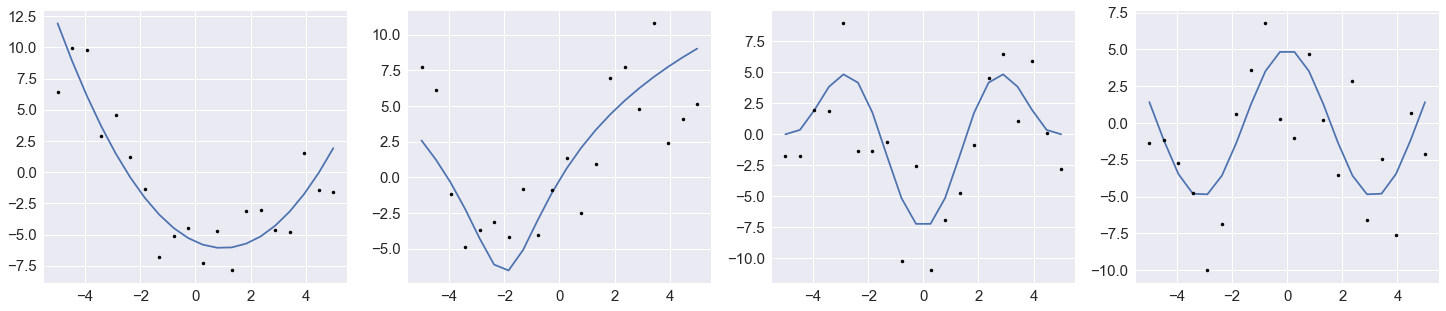

In [11]:
fs = [lambda x: -norm.logpdf(x-1, 0, 1) - 7, lambda x: -4*(tdist.logpdf(x+2, 1) + 2.8), lambda x: 0.3*(x**2 - 25)*np.sin(x+0.5*np.pi), lambda x: 5*np.sin(x+0.5*np.pi)]

sigma2 = 10.

k1, k2 = 5., 2.

N = 20
M = 20
t = np.linspace(-5, 5, N)[:, None]
t2 = np.linspace(-5, 5, M)[:, None]
ys = [f(t) + np.random.normal(0, np.sqrt(sigma2), size=(N, 1)) for f in fs]

plt.figure(figsize = (25, 5))
for idx, (y, f) in enumerate(zip(ys, fs)):
    plt.subplot(1, len(fs), 1 + idx)
    plt.plot(t, f(t))
    plt.plot(t, y, 'k.')

### Result

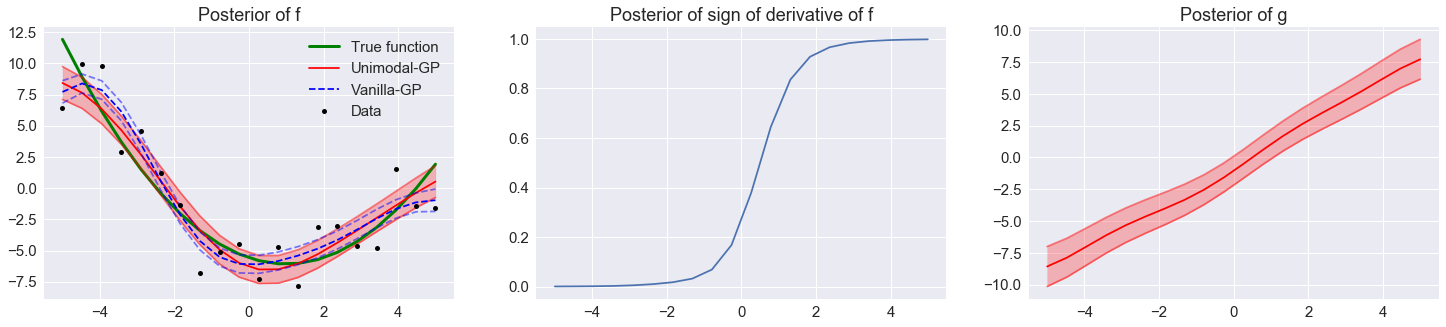

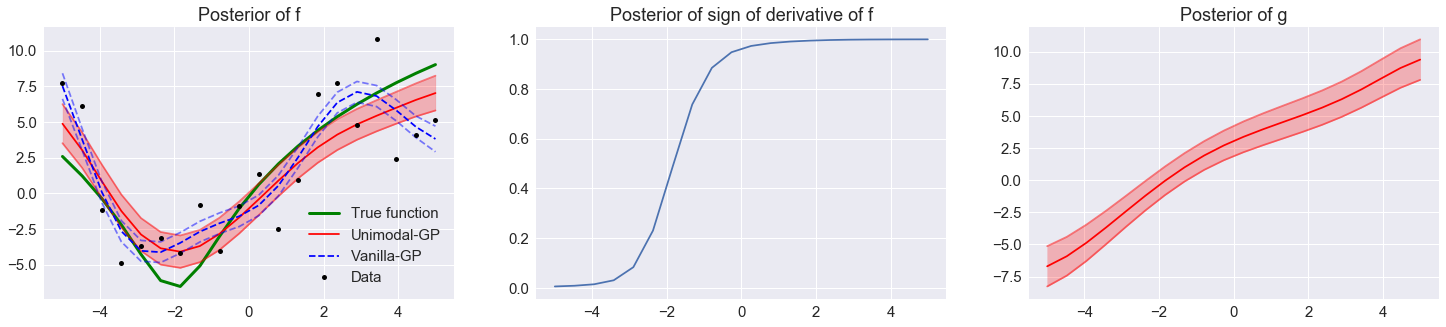

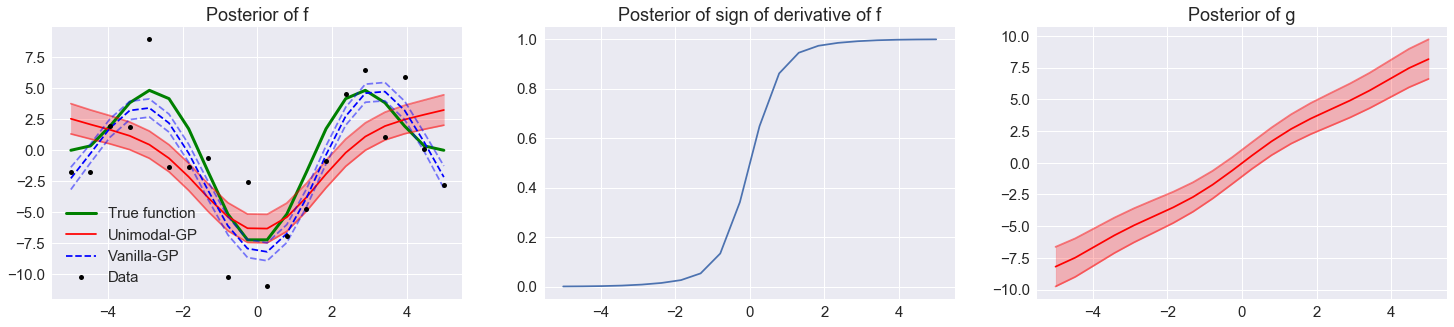

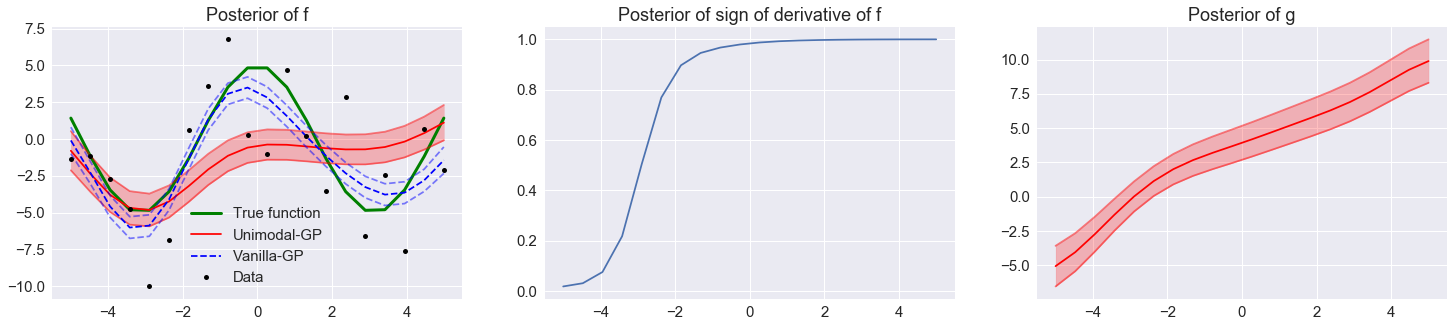

In [12]:
for idx in range(len(ys)):
    f, y = fs[idx](t), ys[idx]

    mu_f, Sigma_f, mu_g, Sigma_g = EP.ep_unimodality(t, y, k1, k2, sigma2, t2=t2, max_itt = 10)
    model = GPy.models.GPRegression(X=t, Y=y, kernel=GPy.kern.RBF(input_dim=1, lengthscale=k2, variance=k1**2))
    mu_gpy, sigma_gpy = model.predict(Xnew=t,include_likelihood=False)

    plt.figure(figsize = (25, 5))
    plt.subplot(1, 3, 1)
    plt.plot(t, f, 'g-', linewidth = 3., label='True function')
    plot_with_uncertainty(x=t, y=mu_f[:N], ystd=np.sqrt(Sigma_f[:N]), label='Unimodal-GP')
    plot_with_uncertainty(x=t, y=mu_gpy, ystd=np.sqrt(sigma_gpy), color='b', fill=False, linestyle='--', label = 'Vanilla-GP')
    plt.plot(t, y, 'k.', markersize=10, label='Data')
    plt.title('Posterior of f')
    plt.legend()

    plt.subplot(1, 3, 2)
    pz = phi(mu_g[:M]/np.sqrt(1 + Sigma_g[:M]))
    plt.plot(t2, pz)
    plt.title('Posterior of sign of derivative of f')

    plt.subplot(1, 3, 3)
    plot_with_uncertainty(x=t2, y=mu_g[:M], ystd=np.sqrt(Sigma_g[:M]))
    plt.title('Posterior of g')